In [146]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# visualisation tools
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
offline.init_notebook_mode()

# modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV

%matplotlib inline
pd.set_option('display.max_columns', 100)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [163]:
df = pd.read_csv('./loans_fs.csv', index_col=0)

/Users/timong/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.



# Objective

The goal of this project is to determine which features would be useful in predicting borrowers who will repay their loan in time

# Key Takeways

1. Most important features to look at in predicting good borrowers are **sub-grade** and **annual income**
2. It was quite difficult to determine the important features with just the use of EDA. As such, I carried on to use machine learning models to further evaluate the importance of each feature

# Data Cleaning

In [149]:
df.head(1)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti
0,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65


In [79]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti
count,8.873790e+05,887379.000000,8.873790e+05,887379.000000,887379.000000,887379.000000,8.873750e+05,8.873790e+05
mean,3.500182e+07,15177.429402,1.890163e+04,14702.464383,13.243805,436.717127,8.237809e+04,-8.562732e+03
std,2.411335e+07,16084.862871,1.115294e+05,8442.106732,4.771725,244.186593,1.488763e+05,1.375036e+05
min,7.047300e+04,-50000.000000,-2.000000e+05,0.000000,1.000000,15.670000,-5.000000e+04,-2.500000e+06
25%,1.087713e+07,8000.000000,8.000000e+03,8000.000000,9.990000,260.705000,4.500000e+04,1.169000e+01
50%,3.709528e+07,13000.000000,1.290000e+04,13000.000000,12.990000,382.550000,6.400000e+04,1.752000e+01
75%,5.847135e+07,20000.000000,2.000000e+04,20000.000000,16.290000,572.600000,9.000000e+04,2.386000e+01
max,7.354484e+07,250000.000000,2.500000e+06,35000.000000,28.990000,1445.460000,9.500000e+06,9.999000e+03


If we were to refer to the data description above, we can see that there are entries where funded amount, loan amount, annual income and debt-to-ratio are negative amount

**Assumption 1: **It is impossible for a funded amount, loan amount, annual income and debt-to-ratio to be negative. I will assume that is a data entry issue and will multipy affected entry by -1

In [150]:
# multiplying negative funded_amnt, loan_amnt, annual_inc, dti by -1
df_clean = (
    df
    .pipe(lambda x: x.assign(funded_amnt = np.where(x.funded_amnt<0, x.funded_amnt*-1, x.funded_amnt)))
    .pipe(lambda x: x.assign(loan_amnt = np.where(x.loan_amnt<0, x.loan_amnt*-1, x.loan_amnt)))
    .pipe(lambda x: x.assign(annual_inc = np.where(x.annual_inc<0, x.annual_inc*-1, x.annual_inc)))
    .pipe(lambda x: x.assign(dti = np.where(x.dti<0, x.dti*-1, x.dti)))
    [[
        'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 
        'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
        'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
        'addr_state', 'dti', 'term', 'pymnt_plan']]
)

In [81]:
df_clean.dti.describe()

count    8.873790e+05
mean     8.598638e+03
std      1.375014e+05
min      0.000000e+00
25%      1.198000e+01
50%      1.778000e+01
75%      2.420000e+01
max      2.500000e+06
Name: dti, dtype: float64

The standard deviation of dti is very large. This could mean that there are outliers in the data. 

**Assumption 2:** Debt-to-income ratio cannot be more or less than IQR +- 1.5 of itself

In [151]:
df_clean.query("funded_amnt_inv > loan_amnt or funded_amnt > loan_amnt or funded_amnt_inv > funded_amnt").shape

(4991, 24)

There exists entries where: 

1. Funded amount by investors is more than loan amount
2. Total funded amount is more than loan amount
3. Funded amount by investors is more than total funded amount

**Assumption 3:** Total funded amount is capped at loan amount request and funded amount by investor is capped at total funded amount

In [83]:
# calculating upper and lower limit of dti
# dti cannot be less than 0 hence, min(0, value)
upper_limit_dti = np.percentile(df_clean.dti, 75) + (stats.iqr(df_clean.dti) * 1.5)
lower_limit_dti = min(0, np.percentile(df_clean.dti, 25) - (stats.iqr(df_clean.dti) * 1.5))

# checking out how many rows will be removed due to erroneous data
erroneous_row_count = (
    df_clean
    .query("funded_amnt_inv > loan_amnt or funded_amnt > loan_amnt or funded_amnt_inv > funded_amnt or dti < {lower} or dti >= {upper}".format(lower=lower_limit_dti, upper=upper_limit_dti))
    .shape[0]
    )

print("erroneous rows: " + str(erroneous_row_count))
print("number of rows in raw data: " + str(df_clean.shape[0]))

erroneous rows: 10073
number of rows in raw data: 887379


In [84]:
# since assumed erroneous rows is only approx ~1.1% of raw data, I will remove them
df_clean = df_clean.query("funded_amnt_inv <= loan_amnt and funded_amnt <= loan_amnt and funded_amnt_inv <= funded_amnt and dti >= {lower} and dti <= {upper}".format(lower=lower_limit_dti, upper=upper_limit_dti))

In [85]:
df_clean.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti
count,8.773060e+05,877306.000000,877306.000000,877306.000000,877306.000000,877306.000000,8.773020e+05,877306.000000
mean,3.499747e+07,14753.444864,14740.069514,14700.564455,13.242085,436.652712,7.503542e+04,18.129166
std,2.411417e+07,8433.803422,8428.333243,8440.571437,4.771488,244.142474,6.485735e+04,8.299734
min,7.047300e+04,500.000000,500.000000,0.000000,1.000000,15.670000,1.896000e+03,0.000000
25%,1.086953e+07,8000.000000,8000.000000,8000.000000,9.990000,260.730000,4.500000e+04,11.910000
50%,3.708661e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000
75%,5.847134e+07,20000.000000,20000.000000,20000.000000,16.290000,572.300000,9.000000e+04,23.950000
max,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,42.370000


In [86]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877306 entries, 0 to 887378
Data columns (total 24 columns):
member_id              877306 non-null int64
loan_amnt              877306 non-null float64
funded_amnt            877306 non-null float64
funded_amnt_inv        877306 non-null float64
int_rate               877306 non-null float64
installment            877306 non-null float64
grade                  877306 non-null object
sub_grade              877306 non-null object
emp_title              826424 non-null object
emp_length             832990 non-null object
home_ownership         877306 non-null object
annual_inc             877302 non-null float64
verification_status    877306 non-null object
issue_d                877306 non-null object
loan_status            877306 non-null object
url                    877306 non-null object
desc                   124657 non-null object
purpose                877306 non-null object
title                  877157 non-null object
zip_code  

In [87]:
df_clean.query("annual_inc != annual_inc")

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,term,pymnt_plan
42449,79912,5000.0,5000.0,3025.0,7.43,155.38,A,A2,NaN,< 1 year,NONE,NaN,Not Verified,Aug-2007,Does not meet the credit policy. Status:Fully ...,https://www.lendingclub.com/browse/loanDetail....,I will be relocating to Boston next month and ...,other,Moving expenses,100xx,NY,1.0,36 months,n
42450,79906,7000.0,7000.0,3450.0,7.75,218.55,A,A3,NaN,< 1 year,NONE,NaN,Not Verified,Aug-2007,Does not meet the credit policy. Status:Fully ...,https://www.lendingclub.com/browse/loanDetail....,"I am borrowing $7,000 for tuition and other ex...",other,Education,100xx,NY,1.0,36 months,n
42480,79878,6700.0,6700.0,6700.0,7.75,209.18,A,A3,NaN,< 1 year,NONE,NaN,Not Verified,Jul-2007,Does not meet the credit policy. Status:Fully ...,https://www.lendingclub.com/browse/loanDetail....,I am moving to Florida and would like to borro...,other,Moving expenses and security deposit,100xx,NY,1.0,36 months,n
42533,70735,6500.0,6500.0,0.0,8.38,204.84,A,A5,NaN,< 1 year,NONE,NaN,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,https://www.lendingclub.com/browse/loanDetail....,"Hi, I'm buying a used car. Anybody on faceb...",other,Buying a car,100xx,NY,4.0,36 months,n


There are missing values in annual_inc and they are all categorised under grade A.

I will impute the null values with the median income of loans that are classified under grade A.

In [88]:
median = df_clean.query("grade == 'A'")[['annual_inc']].median()
print (median)

annual_inc    75000.0
dtype: float64


In [89]:
df_clean['annual_inc'].fillna(75000.0, inplace=True)

# replacing other null values as 'blank'
df_clean.fillna('blank', inplace=True)

# Data Transformation

Since we are interested in analysing borrowers who are willing to make good on their loans, I will remove entries where loan_status = 'Issued' because it does not inform us whether the borrower will make good on his/her loan.

I will classified all loan_status that are "Fully Paid" or "Current" as borrowers who are willing to make payment, i.e. good loans and the rest as borrowers who are unable/unwilling to make payment, i.e. bad loans borrowers. 

In [90]:
# removing loan status "Issued" because it cannot be determine whether borrowers willing to make payment
# obtaining year where loan was issued
# replace blank space with _ for each cell
# good loans = 1 and bad loans = 0 under a new column 'target'
df_transform = (
    df_clean
    .query("loan_status != 'Issued'")
    .pipe(lambda x: x.assign(year = pd.to_datetime(x.issue_d).dt.year))
    .pipe(lambda x: x.assign(verification_status = x.verification_status.str.replace(' ','_')))
    .pipe(lambda x: x.assign(term = x.term.str.replace(' ','_'))).pipe(lambda x: x.assign(
            target = np.where(x.loan_status == 'Fully Paid',1,
                              np.where(x.loan_status == 'Current',1,
                                       np.where(x.loan_status == 'Does not meet the credit policy. Status:Fully Paid',1,0)))))
    )

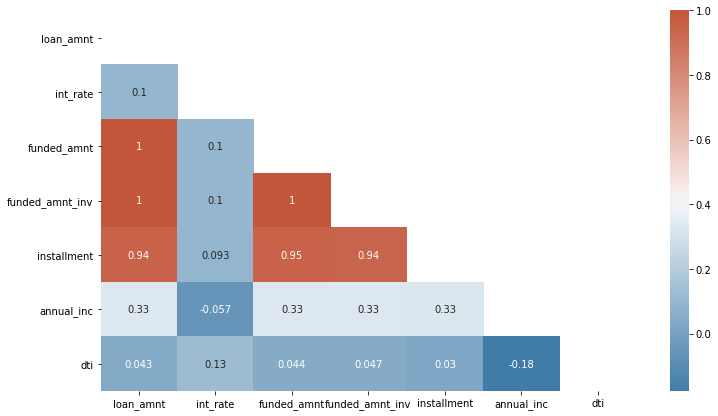

In [91]:
# plotting a correlation heatmap between continuous features
cont_feature_df = df_transform[['loan_amnt', 'int_rate', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti']]

_ = plt.subplots(figsize = (12,7))

corr = cont_feature_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(600, 20, as_cmap=True)

_ = sns.heatmap(corr, mask=mask, annot=True, cmap =cmap)

Since loan amount is perfectly correlated to funded amount, funded amount by investors and highly correlated to installment, I would be removing funded_amnt, funded_amnt_inv and installment from my analysis as they are adequately represened by loan_amnt

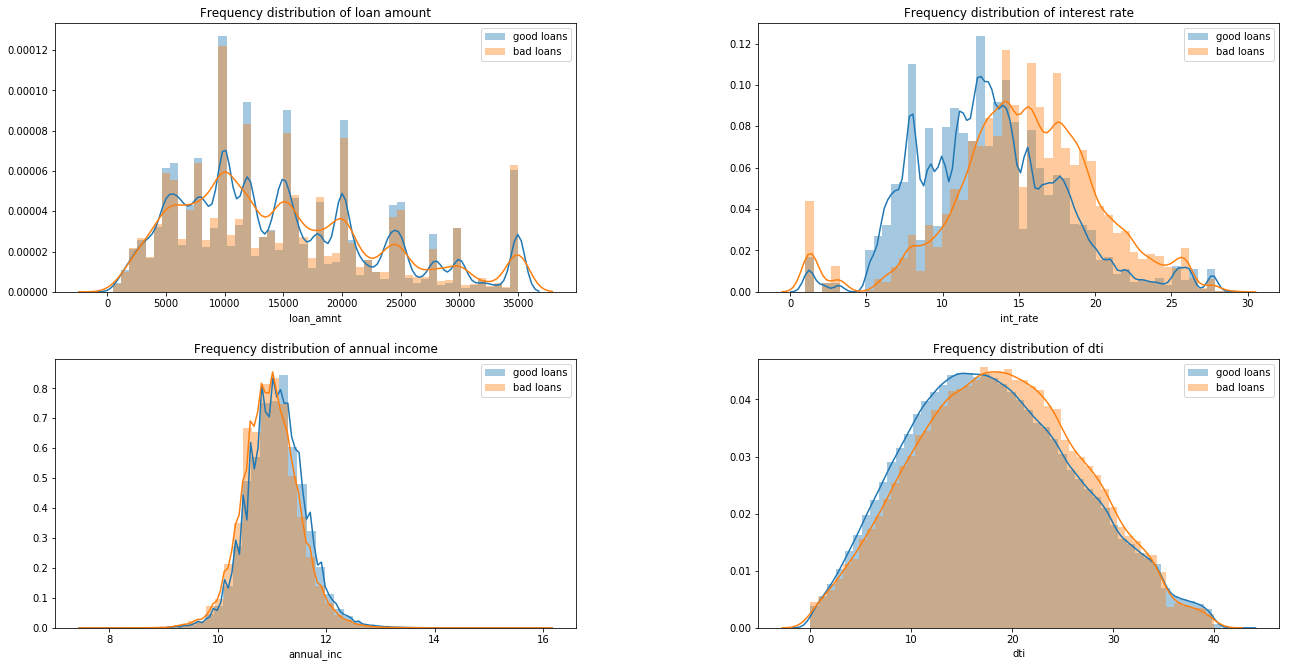

In [92]:
# plotting frequency distribution graphs of continuous features, group by good loan and bad loans
_ = plt.figure(figsize=(20,10))
ax1 = plt.subplot(221)
_ = sns.distplot(df_transform.query("target == 1").loan_amnt, ax=ax1, label='good loans')
_ = sns.distplot(df_transform.query("target == 0").loan_amnt, ax=ax1, label='bad loans')
_ = plt.title("Frequency distribution of loan amount")
_ = ax1.legend()

ax2 = plt.subplot(222)
_ = sns.distplot(df_transform.query("target == 1").int_rate, ax=ax2, label='good loans')
_ = sns.distplot(df_transform.query("target == 0").int_rate, ax=ax2, label='bad loans')
_ = plt.title("Frequency distribution of interest rate")
_ = ax2.legend()

ax3 = plt.subplot(223)
_ = sns.distplot(np.log(df_transform.query("target == 1").annual_inc), ax=ax3, label='good loans')
_ = sns.distplot(np.log(df_transform.query("target == 0").annual_inc), ax=ax3, label='bad loans')
_ = plt.title("Frequency distribution of annual income")
_ = ax3.legend()

ax4 = plt.subplot(224)
_ = sns.distplot(df_transform.query("target == 1").dti, ax=ax4, label='good loans')
_ = sns.distplot(df_transform.query("target == 0").dti, ax=ax4, label='bad loans')
_ = plt.title("Frequency distribution of dti")
_ = ax4.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)

From the frequency distribution charts above, we can see that **interest rate**, **annual income** and **debt-to-income ratio**  have some form of relationship with loan status

In [93]:
cont_feature_df = df_transform[['loan_amnt', 'int_rate', 'annual_inc', 'dti']]

# checking for multi-collinearity amongst continuous features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(cont_feature_df.values, i) for i in range(cont_feature_df.shape[1])]
vif["features"] = cont_feature_df.columns
vif[['features','VIF Factor']]

,features,VIF Factor
0,loan_amnt,4.447659
1,int_rate,5.526292
2,annual_inc,2.485083
3,dti,4.526477


We can see that the VIF factor of the selected continuous features is less than 10, meaning to say that the multi-collinearity relationship amongst them is low

In [94]:
def perf_loans_cat_features(df, column):
    """
    creating dataframe that display the proportion of good/bad loans of each category
    """
    dictionary = {}
    for i in df[column].unique():
        dictionary[i] = round(len(df.query("{}=='{}' and target==1".format(column,i)))/len(df.query("{}=='{}'".format(column,i))) * 100,1)
    column_df = (
        pd.DataFrame(list(dictionary.items()), columns=[column, 'pctg_good_loans'])
        .pipe(lambda x: x.assign(total=100))
        .pipe(lambda x: x.assign(pctg_bad_loans=x.total-x.pctg_good_loans))
        .sort_values(column)
        .reset_index()
        [[column, 'pctg_good_loans', 'pctg_bad_loans', 'total']]
    )
    
    return column_df

In [95]:
grades_df = perf_loans_cat_features(df_transform, 'grade')
sub_grades_df = perf_loans_cat_features(df_transform, 'sub_grade')
emp_length_df = perf_loans_cat_features(df_transform, 'emp_length')
home_ownership_df = perf_loans_cat_features(df_transform, 'home_ownership')
verification_status_df = perf_loans_cat_features(df_transform, 'verification_status')
term_df = perf_loans_cat_features(df_transform, 'term')
payment_plan_df = perf_loans_cat_features(df_transform, 'pymnt_plan')
purpose_df = perf_loans_cat_features(df_transform, 'purpose')
state_df = perf_loans_cat_features(df_transform, 'addr_state')
year_df = perf_loans_cat_features(df_transform, 'year')

In [96]:
# example of the output of perf_loans_cat_features function
grades_df

,grade,pctg_good_loans,pctg_bad_loans,total
0,A,97.5,2.5,100
1,B,94.7,5.3,100
2,C,92.2,7.8,100
3,D,88.5,11.5,100
4,E,86.1,13.9,100
5,F,80.8,19.2,100
6,G,76.7,23.3,100


In [97]:
cat_feature_df = [grades_df, sub_grades_df, emp_length_df, home_ownership_df, verification_status_df, term_df, payment_plan_df, purpose_df, year_df]
cat_feature_list = ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'term', 'pymnt_plan', 'purpose', 'year']

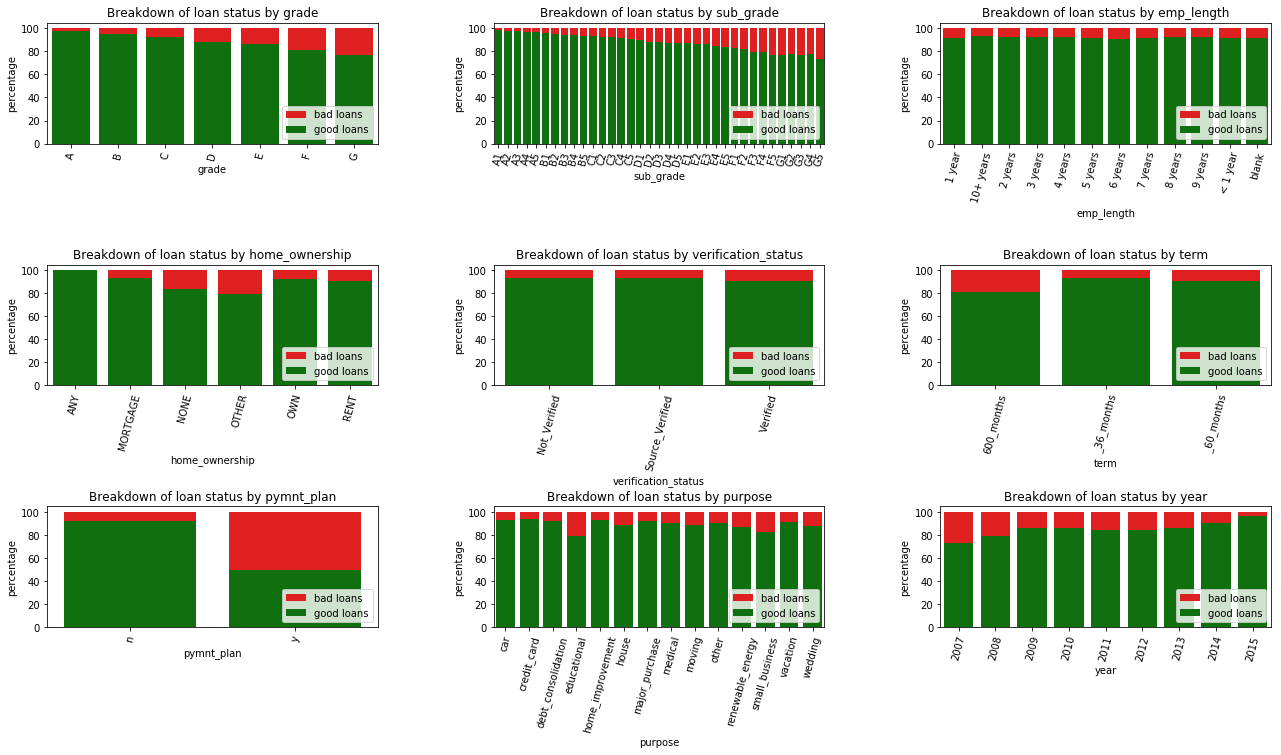

In [98]:
# plotting a percentage stacked bar chart of all the categorical features to visualise the proportion of bad loans and good loans
_ = plt.figure(figsize=(20,10))
start = 331
for idx, (df, col )in enumerate(zip(cat_feature_df, cat_feature_list)):
    _ = plt.subplot(start + idx)
    overall_plot = sns.barplot(x = df[col], y = df.total, color = "red", label='bad loans')
    bottom_plot = sns.barplot(x = df[col], y = df.pctg_good_loans, color = "green", label='good loans')
    _ = plt.title('Breakdown of loan status by ' + col)
    _ = plt.legend(loc=4, ncol = 1)
    _ = plt.ylabel('percentage')
    _ = plt.xticks(rotation=75, fontsize='10')
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1, wspace=0.35)

From the percentage stacked bar charts above, we can see that **all of the categorical features** other than **employment length** and **verification status** have a certain relation to the status of the loan.

Although we can see that the percentage of bad loans is decreasing over the years, I will not be conducting a time series analysis.
The reason why the percentage of bad loans are decreasing over the years is probably due to the fact that the global economy is steadily recovering from the 07/08 financial crisis. From this, we can see that the state of global economy has a part to play in determining whether a loan will be defaulted. If time permits, I might include leading economic indicator(s) in my analysis. 

In [99]:
# plotting heatmap of bad loan rate in each state
state_df2 = state_df
for col in state_df2.columns:
    state_df2[col] = state_df2[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

state_df2['text'] = state_df2['addr_state'] + '<br>' +\
    'Percentage of bad loans: '+state_df2['pctg_bad_loans']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_df2['addr_state'],
        z = state_df2['pctg_bad_loans'].astype(float),
        locationmode = 'USA-states',
        text = state_df2['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Percentage"
        )
    ) ]

layout = dict(
        title = 'Percentage of bad loans in each state<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout )

iplot(fig, filename='d3-cloropleth-map')

From the US heatmap above, Iowa has the highest proportion of bad loans while Maine, North Dakota and Nebraska have the lowest proportion of bad loans

# Feature Importance

Although the EDA above gave us a good sensing on what features are important in determining whether a loan will be paid back/paid on time, we do not know how each of them affect one another. As such, I would be conducting a feature importance study to understand which are the most important features in predicting whether a loan would be repaid back on time.

In [100]:
print(df_transform.columns)

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'term', 'pymnt_plan', 'year', 'target'],
      dtype='object')


In [101]:
# dropping irrevelant columns
df_model_1 = df_transform.drop([
        "member_id", "funded_amnt", "funded_amnt_inv", "installment", "emp_title", "issue_d", "year", \
        "loan_status", "url", "desc","title", "zip_code"], axis=1)

In [102]:
cat_feature_list = [i for i in df_model_1.columns if i not in cont_feature_df.columns]

In [103]:
print(cat_feature_list)

['grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'term', 'pymnt_plan', 'target']


In [104]:
# applying one-hot encoding for categorical variables
df_model_1 = (
    pd.get_dummies(df_model_1, columns=[i for i in cat_feature_list if i != 'target'], \
                   prefix=[i for i in cat_feature_list if i != 'target'], drop_first=True)
)

In [105]:
df_model_1.head(1)

,loan_amnt,int_rate,annual_inc,dti,target,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,...,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,term__36_months,term__60_months,pymnt_plan_y
0,5000.0,10.65,24000.0,27.65,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [106]:
df_model_1.shape

(868956, 129)

In [107]:
print('number of good loans: ' + str(df_model_1.query("target==1").shape[0]))
print('number of bad loans: ' + str(df_model_1.query("target==0").shape[0]))

number of good loans: 802270
number of bad loans: 66686


We can see that the data is skewed. I will under-sample the the data of good loans to obtain a data set where good and bad loans are proportionate, i.e. baseline accuracy = 0.5

In [108]:
def under_sampling_good_loans(df):
    good_df = df.query("target==1")
    bad_df = df.query("target==0")
    good_sample_df = good_df.sample(n=bad_df.shape[0], random_state=13)
    final_df = pd.concat([bad_df, good_sample_df], axis=0, ignore_index=True)
    
    return final_df

In [109]:
df_model_1 = under_sampling_good_loans(df_model_1)

In [110]:
x = df_model_1[[i for i in df_model_1.columns if i != 'target']]
y = df_model_1['target']

In [111]:
# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

In [112]:
# using min-max scaler so that my data will be within 1 and 0
mm = MinMaxScaler()
x_mm_train = mm.fit_transform(x_train)
x_mm_test = mm.transform(x_test)

In [38]:
# using gridsearch to optimise my selected model
gs_params ={
    'max_depth': np.linspace(1,129,5,dtype=int),
    'n_estimators':np.linspace(10,100,5,dtype=int),
    'random_state':[13]
}

# choosing random forest as my base model
rclf_gs = GridSearchCV(RandomForestClassifier(), gs_params, n_jobs = -1, verbose = 1, cv = 3)

In [39]:
rclf_gs.fit(x_mm_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([  1,  33,  65,  97, 129]), 'n_estimators': array([ 10,  32,  55,  77, 100]), 'random_state': [13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [40]:
rclf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=33, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [113]:
rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=33, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=13, verbose=1, warm_start=False)
rfclf.fit(x_mm_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.6s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=33, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=13, verbose=1, warm_start=False)

In [42]:
def model_perf(model, X_test, y_test):
    """ 
    Evaluating performance of supervised models
    Returns
    -----------
    Model score, precision score (minority class), recall score (minority class),
    f1 score (minority class) and auc score (unweighted average)
    """
    model_yhat = model.predict(X_test)
    model_score = model.score(X_test, y_test)
    model_f1 = f1_score(y_test, model_yhat)
    model_precision = precision_score(y_test, model_yhat)
    model_recall = recall_score(y_test, model_yhat)
    model_auc = roc_auc_score(y_test, model_yhat)
    
    return (model_score, model_precision, model_recall, model_f1, model_auc)

In [114]:
model_score, model_precision, model_recall, model_f1, model_auc = model_perf(rfclf, x_mm_test, y_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [115]:
model_perf_df = pd.DataFrame({'rf_all_features':[model_score, model_precision, model_recall, model_f1, model_auc]},
                      index = ['model score','precision score','recall score','f1 score', 'auc'])
model_perf_df

,rf_all_features
model score,0.667950
precision score,0.679116
recall score,0.627907
f1 score,0.652508
auc,0.667671


In [116]:
feature_impt_df = (
    pd.DataFrame(rfclf.feature_importances_, index=x.columns, columns=['importance'])
    .reset_index()
    .rename(columns={"index":"features"})
    .sort_values('importance', ascending=False)
    .pipe(lambda x: x.assign(cumulative_sum=x.importance.cumsum()))
    .reset_index(drop=True)
    )
feature_impt_df  

,features,importance,cumulative_sum
0,int_rate,0.168165,0.168165
1,dti,0.109677,0.277842
2,annual_inc,0.106555,0.384397
3,loan_amnt,0.095408,0.479805
4,emp_length_10+ years,0.014383,0.494188
5,verification_status_Verified,0.014361,0.508549
6,purpose_debt_consolidation,0.014104,0.522652
7,verification_status_Source_Verified,0.013772,0.536425
8,addr_state_CA,0.012769,0.549194
9,purpose_credit_card,0.011340,0.560534


In [118]:
shortlisted_features_df = feature_impt_df.query("importance >= 1/129")
shortlisted_features_df

,features,importance,cumulative_sum
0,int_rate,0.168165,0.168165
1,dti,0.109677,0.277842
2,annual_inc,0.106555,0.384397
3,loan_amnt,0.095408,0.479805
4,emp_length_10+ years,0.014383,0.494188
5,verification_status_Verified,0.014361,0.508549
6,purpose_debt_consolidation,0.014104,0.522652
7,verification_status_Source_Verified,0.013772,0.536425
8,addr_state_CA,0.012769,0.549194
9,purpose_credit_card,0.011340,0.560534


I have used random forest to determine feature importance.

Since there are 129 features, a feature would be given a 0.00775(1/129) importance score on average. As such, the above dataframe is a filter that shows us features that are above the average score and it is ranked by feature importance, where the first feature is the most important

We can see that 25 features are selected. The end result may not be very intiutive from a business point of view as there are too many one-hot encoded features.

I will attempt to reduce the number of one-hot encoded features while maintaining the model performance.

# Data Cleaning and Transformation Part 2

In [119]:
# converting grade and sub_grade into continuous variable
grade_dict = {"A":1.0, "B":2.0, "C":3.0, "D":4.0, "E":5.0, "F":6.0, "G":7.0}
sub_grade_dict = {
    "A1":1.0, "A2":1.2, "A3":1.4, "A4":1.6, "A5":1.8,
    "B1":2.0, "B2":2.2, "B3":2.4, "B4":2.6, "B5":2.8,
    "C1":3.0, "C2":3.2, "C3":3.4, "C4":3.6, "C5":3.8,
    "D1":4.0, "D2":4.2, "D3":4.4, "D4":4.6, "D5":4.8,
    "E1":5.0, "E2":5.2, "E3":5.4, "E4":5.6, "E5":5.8,
    "F1":6.0, "F2":6.2, "F3":6.4, "F4":6.6, "F5":6.8,
    "G1":7.0, "G2":7.2, "G3":7.4, "G4":7.6, "G5":7.8
    }
emp_length_dict={
    "10+ years":10, "< 1 year":0, "1 year":1, "2 years":2, "3 years":3,
    "4 years":4, "5 years":5, "6 years":6, "7 years":7, "8 years":8, "9 years":9
    }

In [120]:
df_transform_2 = df_transform
df_transform_2['grade'] = [grade_dict[i] for i in df_transform_2['grade']]
df_transform_2['sub_grade'] = [sub_grade_dict[i] for i in df_transform_2['sub_grade']]  
df_transform_2['emp_length'] = [emp_length_dict[i] if i != 'blank' else np.nan for i in df_transform_2['emp_length']]

In [121]:
df_transform_2['emp_length'].describe()

count    825262.000000
mean          6.009078
std           3.665247
min           0.000000
25%           3.000000
50%           6.000000
75%          10.000000
max          10.000000
Name: emp_length, dtype: float64

In [122]:
# replacing null values in emp_length with its median value
df_transform_2['emp_length'].fillna(6, inplace=True)

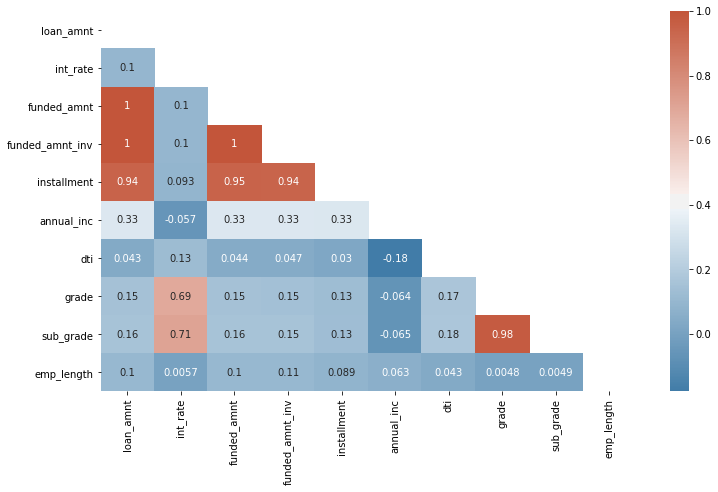

In [123]:
# plotting a heatmap of a correlation matrix of all the continuous features
cont_feature_df = df_transform_2[['loan_amnt', 'int_rate', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'grade', 'sub_grade', 'emp_length']]

_ = plt.subplots(figsize = (12,7))

corr = cont_feature_df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(600, 20, as_cmap=True)

_ = sns.heatmap(corr, mask=mask, annot=True, cmap =cmap)

Since interest rate, grade and sub_grade are highly correlated, we will be removing two of them. However, which two should we be removing?

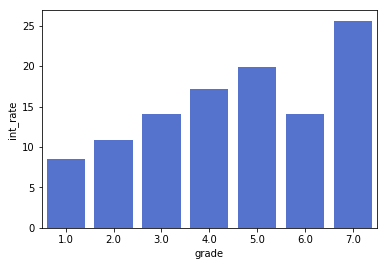

In [124]:
grade_explore = (
    df_transform_2
    [['int_rate', 'grade']]
    .groupby("grade")
    .agg({"int_rate": "mean"})
    .reset_index()
)
_ = sns.barplot(x='grade', y='int_rate', data=grade_explore, color='royalblue')

There appears to be some anomaly in the data as the average interest rate of grade F (6.0) is similar to the average interest rate of grade C (3.0)

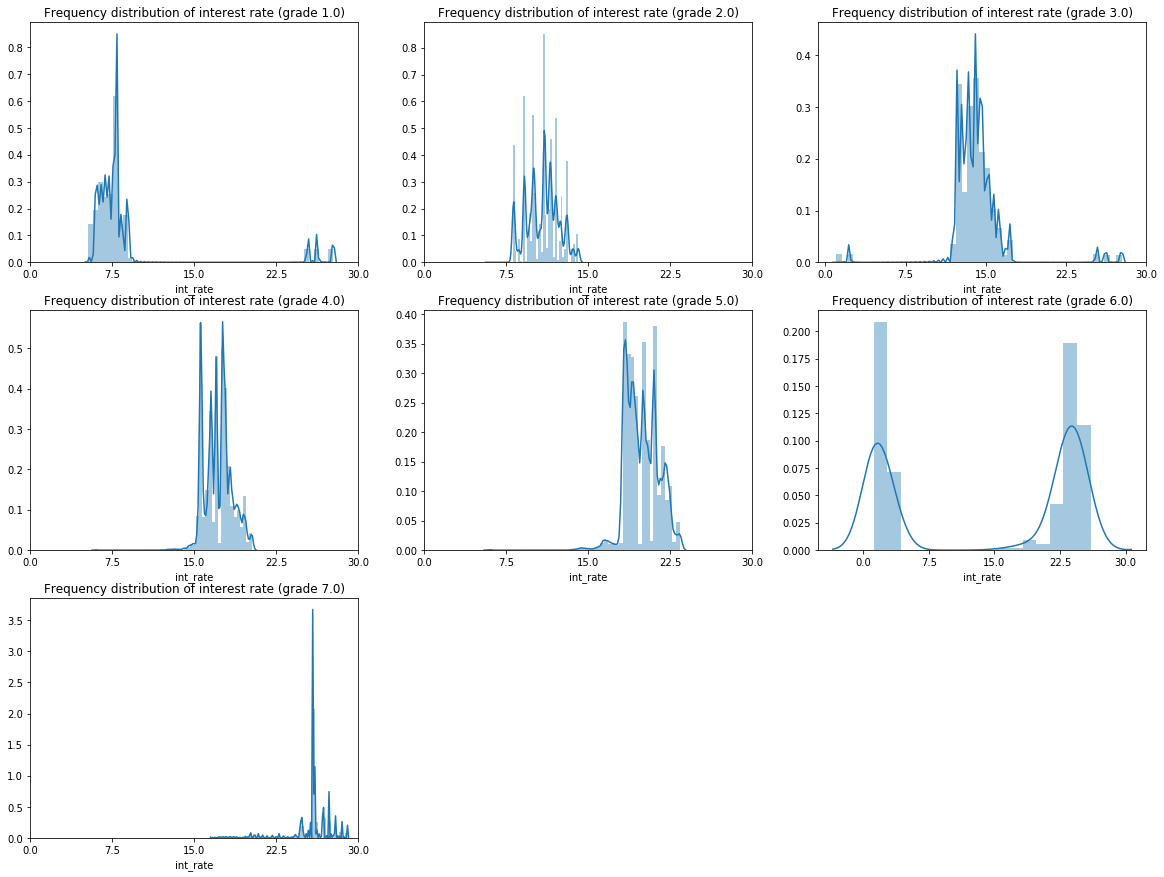

In [125]:
# plotting the frequency distribution of interest rate of each grade
_ = plt.figure(figsize=(20,15))
for idx, g in enumerate(sorted(df_transform_2.grade.unique())):
    start_subplot = 331
    _ = plt.subplot(start_subplot + idx, )
    _ = sns.distplot(df_transform_2.query("grade=={}".format(g)).int_rate)
    _ = plt.xticks(np.linspace(0,30,5))
    _ = plt.title('Frequency distribution of interest rate (grade ' + str(g) + ')')

From the graphs above, we can see that there are some errerroneous data in grade F (6.0). Half of grade F loans have interest rate less than 7.5% which is an anomaly. Due to an interest of time I will drop these rows as instead of conducting further analysis as I would still retain ~10k rows of grade F loans which will suffice during modelling stage

In [126]:
index_to_drop = df_transform_2.query("grade==6 and int_rate <= 7.5").index.values
df_clean_2 = (
    df_transform_2.
    drop(index_to_drop, axis=0)
    .reset_index()
    )

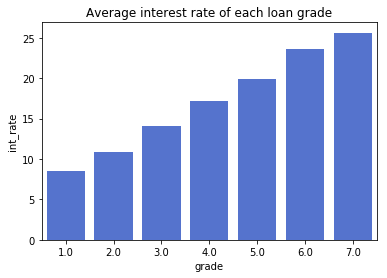

In [127]:
# re-plotting the bar chart showing the relationship between interest rate and grade
grade_explore = (
    df_clean_2
    [['int_rate', 'grade']]
    .groupby("grade")
    .agg({"int_rate": "mean"})
    .reset_index()
)
_ = sns.barplot(x='grade', y='int_rate', data=grade_explore, color='royalblue')
_ = plt.title('Average interest rate of each loan grade')

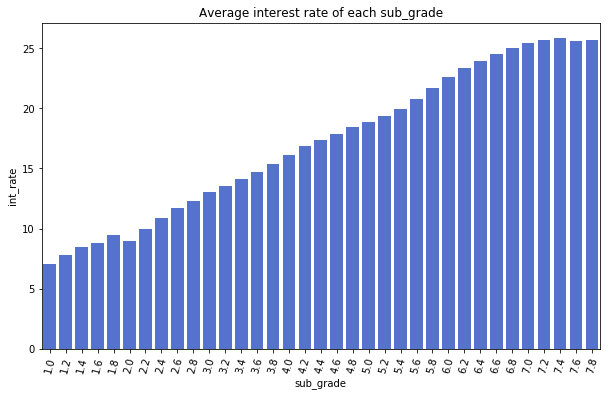

In [128]:
# plotting bar chart showing the relationship between interest rate and sub_grade
sub_grade_explore = (
    df_clean_2
    [['int_rate', 'sub_grade']]
    .groupby("sub_grade")
    .agg({"int_rate": "mean"})
    .reset_index()
)
_ = plt.figure(figsize=(10,6))
_ = sns.barplot(x='sub_grade', y='int_rate', data=sub_grade_explore, color='royalblue')
_ = plt.title('Average interest rate of each sub_grade')
_ = plt.xticks(rotation=75, fontsize='10')

From the correlation heatmap plot, we can see that interest rate has a high correlation with grade and sub_grade. As such, we can remove 2 of the three features in our model.

From the grade bar chart, we can see that there is an obvious difference in interet rate between each grade. Whereas from the sub_grade bar chart we can see that interest rate can be hardly differeniated at the tail end of the sub_grade list (G1 to G5). As such I will retain sub_grade and remove grade and interest rate in my model.

In [129]:
df_transform_2 = df_clean_2
df_transform_2.columns

Index(['index', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'term', 'pymnt_plan', 'year', 'target'],
      dtype='object')

In [130]:
df_model_2 = df_transform_2[['loan_amnt', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', \
                             'purpose', 'addr_state', 'dti', 'term', 'pymnt_plan', 'target']]

cat_feature_list = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'term', 'pymnt_plan']
cont_feature_list = ['loan_amnt', 'sub_grade', 'emp_length', 'annual_inc', 'dti']

In [131]:
# applying one-hot encoding to my categorical features
df_model_2 = pd.get_dummies(df_model_2, columns=[i for i in cat_feature_list], prefix=[i for i in cat_feature_list], drop_first=True)

In [132]:
df_model_2.columns

Index(['loan_amnt', 'sub_grade', 'emp_length', 'annual_inc', 'dti', 'target',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source_Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'addr_state_AL', 'addr_state_AR',
       'addr_state_AZ', 'addr_state_CA', 'addr_state_CO', 'addr_state_CT',
       'addr_state_DC', 'addr_state_DE', 'addr_state_FL', 'addr_state_GA',
       'addr_state_HI', 'addr_state_IA', 'addr_state_ID', 'addr_state_IL',
       'addr_state_IN', 'addr_state_KS', 'addr_state_KY', 'addr_state_LA',
       'addr_state_MA', 'addr_state_MD', 'addr_s

In [133]:
df_model_2.shape

(859145, 79)

In [134]:
# calculating the proportion of 1s in my one-hot encoded categorical features
pctg_of_1s_in_cat_feature_dict = {}
one_hot_encoding_feature_list = [i for i in df_model_2.columns if i not in cont_feature_list and i != 'target']
for i in one_hot_encoding_feature_list:
    pctg_of_1s_in_cat_feature_dict[i] = df_model_2.query("{} == 1".format(i)).shape[0]/df_model_2.shape[0] * 100

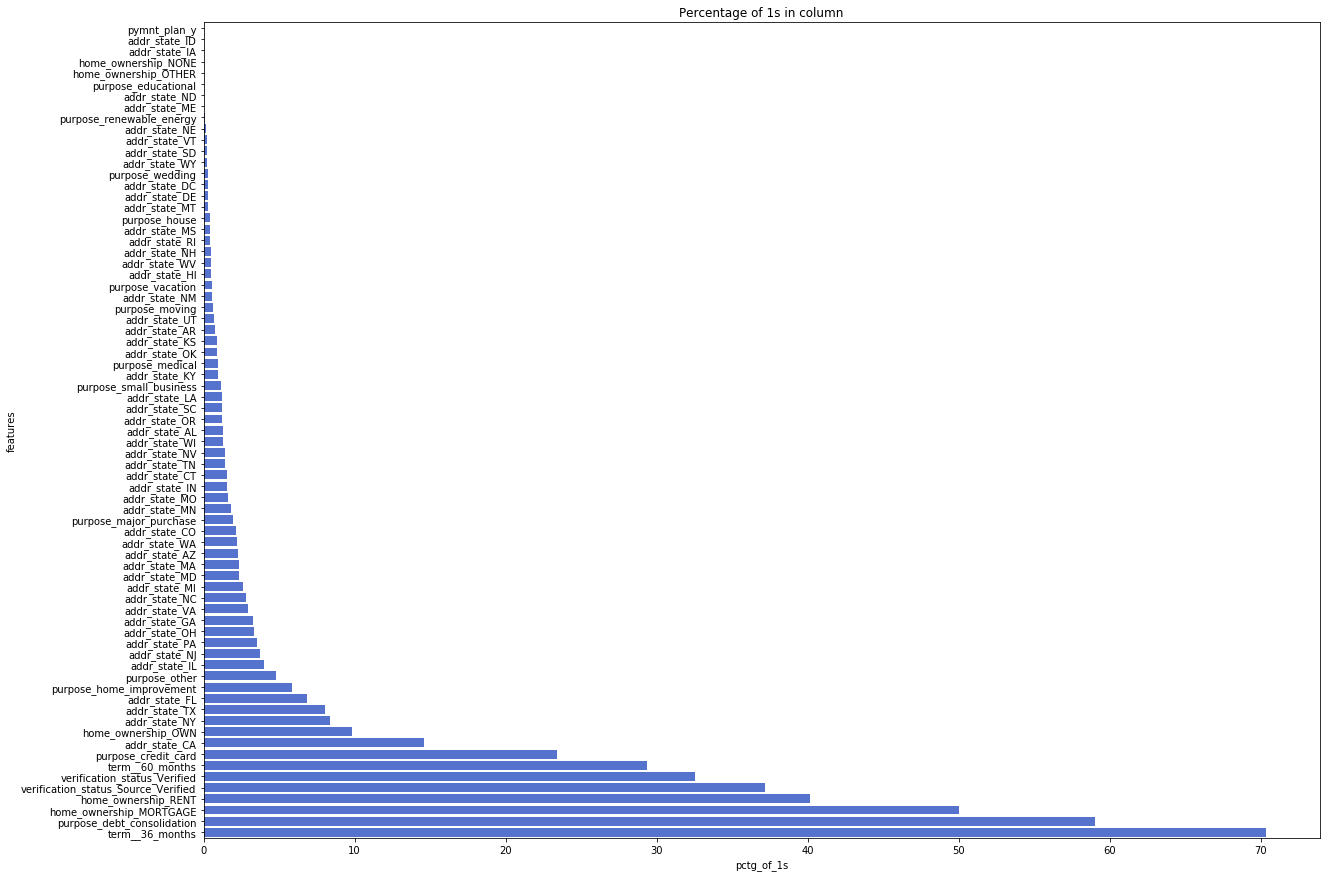

In [152]:
pctg_of_1s_in_cat_feature_df = (
    pd.DataFrame(list(pctg_of_1s_in_cat_feature_dict.items()), columns=['features', 'pctg_of_1s'])
    .sort_values('pctg_of_1s')
    )

_ = plt.figure(figsize=(20,15))
_ = sns.barplot(x='pctg_of_1s', y='features', data=pctg_of_1s_in_cat_feature_df, color='royalblue', orient="h")
_ = plt.title("Percentage of 1s in column")

The chart above shows us the percentage of 1's of all the one-hot encoded features.

If a feature has too many rows of the same value, the coefficient of that feature would not give us much information because it would be bias towards dominant value. 

As such, I will remove features that are 90% filled with the same value

In [136]:
pctg_of_1s_in_cat_feature_df.query("pctg_of_1s >= 10 and pctg_of_1s <= 90").features.unique()

array(['addr_state_CA', 'purpose_credit_card', 'term__60_months',
       'verification_status_Verified',
       'verification_status_Source_Verified', 'home_ownership_RENT',
       'home_ownership_MORTGAGE', 'purpose_debt_consolidation',
       'term__36_months'], dtype=object)

In [137]:
cont_feature_list

['loan_amnt', 'sub_grade', 'emp_length', 'annual_inc', 'dti']

In [138]:
df_model_2 = df_model_2[['loan_amnt', 'sub_grade', 'emp_length', 'annual_inc', 'dti',\
                        'addr_state_CA', 'purpose_credit_card', 'term__60_months','verification_status_Verified', \
                        'verification_status_Source_Verified', 'home_ownership_RENT','home_ownership_MORTGAGE', \
                        'purpose_debt_consolidation','term__36_months', 'target']]

In [139]:
df_model_2.shape

(859145, 15)

In [140]:
df_model_2 = under_sampling_good_loans(df_model_2)

x = df_model_2[[i for i in df_model_2.columns if i != 'target']]
y = df_model_2['target']

# split data train 70 % and test 30 %
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

# using min-max scaler so that my data will be within 1 and 0
x_mm_train = mm.fit_transform(x_train)
x_mm_test = mm.transform(x_test)

In [69]:
gs_params ={
    'max_depth': np.linspace(1,15,3,dtype=int),
    'n_estimators':np.linspace(10,100,5,dtype=int),
    'random_state':[13]
}

rclf_gs = GridSearchCV(RandomForestClassifier(), gs_params, n_jobs = -1, verbose = 1, cv = 3)

rclf_gs.fit(x_mm_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   49.4s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': array([ 1,  8, 15]), 'n_estimators': array([ 10,  32,  55,  77, 100]), 'random_state': [13]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [70]:
rclf_gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [141]:
rfclf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=-1,
            oob_score=False, random_state=13, verbose=1, warm_start=False)

rfclf.fit(x_mm_train, y_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:    1.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=-1,
            oob_score=False, random_state=13, verbose=1, warm_start=False)

In [143]:
model_score_2, model_precision_2, model_recall_2, model_f1_2, model_auc_2 = model_perf(rfclf, x_mm_test, y_test)
model_perf_df = pd.DataFrame({'rf_all_features':[model_score, model_precision, model_recall, model_f1, model_auc],
                             'rf_reduced_features': [model_score_2, model_precision_2, model_recall_2, model_f1_2, model_auc_2]},
                      index = ['model score','precision score','recall score','f1 score', 'auc'])
model_perf_df

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 out of  77 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  77 out of  77 | elapsed:    0.1s finished


,rf_all_features,rf_reduced_features
model score,0.667950,0.630858
precision score,0.679116,0.636698
recall score,0.627907,0.594222
f1 score,0.652508,0.614727
auc,0.667671,0.630538


In [144]:
feature_impt_df = (
    pd.DataFrame(rfclf.feature_importances_, index=x.columns, columns=['importance'])
    .reset_index()
    .rename(columns={"index":"features"})
    .sort_values('importance', ascending=False)
    .pipe(lambda x: x.assign(cumulative_sum=x.importance.cumsum()))
    .reset_index(drop=True)
    )
feature_impt_df  

,features,importance,cumulative_sum
0,sub_grade,0.570812,0.570812
1,annual_inc,0.113106,0.683918
2,dti,0.057790,0.741709
3,verification_status_Verified,0.052740,0.794449
4,loan_amnt,0.050128,0.844577
5,purpose_credit_card,0.033116,0.877693
6,term__36_months,0.024531,0.902224
7,home_ownership_RENT,0.022185,0.924409
8,emp_length,0.017985,0.942394
9,verification_status_Source_Verified,0.017878,0.960272


In [145]:
shortlisted_features_df = feature_impt_df.query("importance >= 1/13")
shortlisted_features_df

,features,importance,cumulative_sum
0,sub_grade,0.570812,0.570812
1,annual_inc,0.113106,0.683918


# Conclusion

Although the revised random forest model gave a lower score on model performance as compared to the original model, the difference was not a lot, ~3%.

However, the result of the feature importance is much clearer and more intuitive to business users. The top features are **sub_grade** and **annual_inc**.

# Considerations

1. To engineer a new feature that gives a scoring on the sentiment of the 'description' and 'title' columns (sentiment analysis)
2. To include leading economic indicator(s) as addition feature(s)
3. Create a total of 3 folds to cross-validate my model
4. Use lasso regression to conduct feature selection
5. Use recursive feature elimination to conduct feature selection 
6. Use decision tree to plot out the how decisions are branched out